# 시계열 데이터를 다뤄보자

프로그램 설치
```
conda install -c anaconda pandas-datareader
conda install -c conda-forge pystan¶
conda install -c conda-forge fbprophet
conda install -c plotly plotly
```

## 7-1 Numpy의 polyfit으로 회귀(regression) 분석하기

In [1]:
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
import time
import json
import re
import pandas as pd
import pandas_datareader.data as web
import numpy as np

# Prophet is a forecasting procedure implemented in R and Python. It is fast and provides completely automated forecasts that can be tuned by hand by data scientists and analysts.
from fbprophet import Prophet

# A Fast, Extensible Progress Bar for Python and CLI
from tqdm import tqdm

# matplotlib: plotting with Python.
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager
%matplotlib inline

# A module for finding, managing, and using fonts across platforms.
mpl.font_manager._rebuild()
sorted([f.name for f in mpl.font_manager.fontManager.ttflist if f.name.startswith('Malgun')])

# 폰트 설정
mpl.rc('font', family='Malgun Gothic')

# 유니코드에서  음수 부호설정
mpl.rc('axes', unicode_minus=False)

Importing plotly failed. Interactive plots will not work.


## 7-2 Prophet 모듈을 이용한 forcast 예측

In [2]:
pinkwink_web = pd.read_csv('./data/08. PinkWink Web Traffic.csv', 
    encoding='utf-8', 
    thousands=',', 
    names=['date', 'hit'], 
    index_col=0
)
pinkwink_web = pinkwink_web[pinkwink_web['hit'].notnull()]
pinkwink_web.head()

hit
date            
16. 7. 1.  766.0
16. 7. 2.  377.0
16. 7. 3.  427.0
16. 7. 4.  902.0
16. 7. 5.  850.0

<AxesSubplot:xlabel='date'>

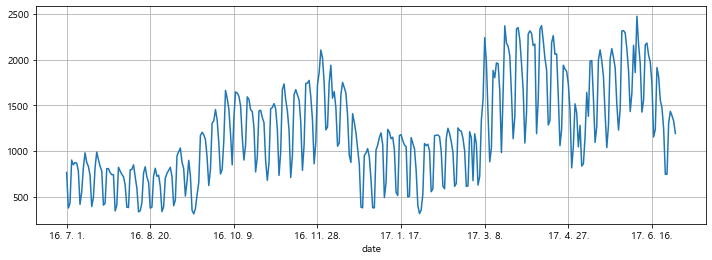

In [3]:
pinkwink_web['hit'].plot(figsize=(12,4), grid=True)

In [4]:
time = np.arange(0, len(pinkwink_web))
traffic = pinkwink_web['hit'].values

fx = np.linspace(0, time[-1], 1000)

In [5]:
def error(f, x, y):
    return np.sqrt(np.mean(f(x)-y**2))

어떤 데이터를 어떤 모델로 표현하려고 하면 그 모델의 적합성을 확인하는 과정이 필요합니다. 그러기 위해서는 참 값과 비교해서 에러(error)를 계산해야 합니다.

In [6]:
fp1 = np.polyfit(time, traffic, 1)
f1 = np.poly1d(fp1)

fp2 = np.polyfit(time, traffic, 2)
f2 = np.poly1d(fp2)

fp3 = np.polyfit(time, traffic, 3)
f3 = np.poly1d(fp3)

fp15 = np.polyfit(time, traffic, 15)
f15 = np.poly1d(fp15)

print(error(f1, time, traffic))
print(error(f2, time, traffic))
print(error(f3, time, traffic))
print(error(f15, time, traffic))

nan
nan
nan
nan


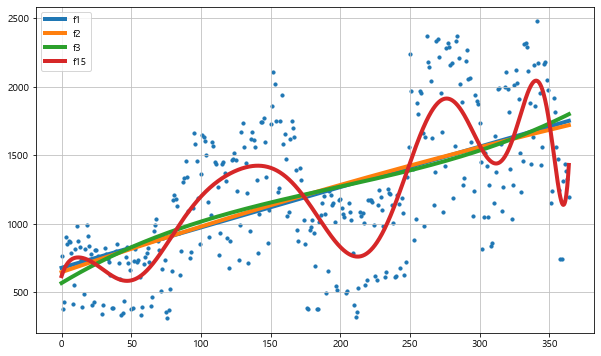

In [7]:
plt.figure(figsize=(10,6))
plt.scatter(time, traffic, s=10)

plt.plot(fx, f1(fx), lw=4, label='f1')
plt.plot(fx, f2(fx), lw=4, label='f2')
plt.plot(fx, f3(fx), lw=4, label='f3')
plt.plot(fx, f15(fx), lw=4, label='f15')

plt.grid(True, linestyle='-', color='0.75')
plt.legend(loc=2)
plt.show()

## 7-3 Seasonal 시계열 분석으로 주식 데이터 분석하기

In [8]:
df = pd.DataFrame({
    'ds': pinkwink_web.index,
    'y': pinkwink_web['hit']
})
df.reset_index(inplace=True)
df['ds'] = pd.to_datetime(df['ds'], format='%y. %m. %d.')
del df['date']

m = Prophet(yearly_seasonality=True)
m.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [9]:
future = m.make_future_dataframe(periods=60)
future.tail()

ds
420 2017-08-25
421 2017-08-26
422 2017-08-27
423 2017-08-28
424 2017-08-29

In [10]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds         yhat   yhat_lower   yhat_upper
420 2017-08-25   908.312485   694.415735  1114.329685
421 2017-08-26   493.269868   281.074163   707.162867
422 2017-08-27   625.855539   409.061873   855.621223
423 2017-08-28  1178.497203   971.011608  1397.531924
424 2017-08-29  1214.444999  1015.115681  1434.890518

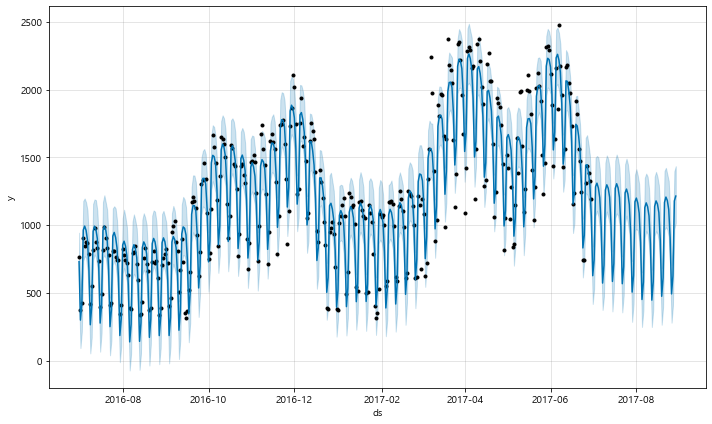

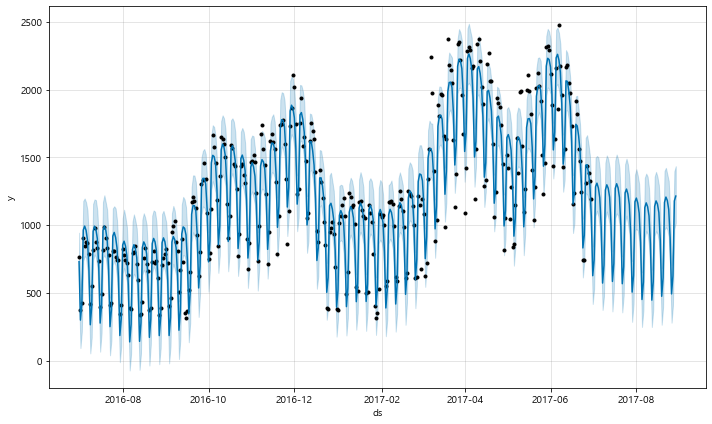

In [11]:
m.plot(forecast)

앞으로의 예측부터 주별, 연간, 데이터의 현황도 알 수 있게 되었습니다. 비록 빈약하긴 하지만 이러한 과정을 Seasonal 시계열 데이터 분석(Seasonal Time Series Data Analysis) 이라고 합니다.

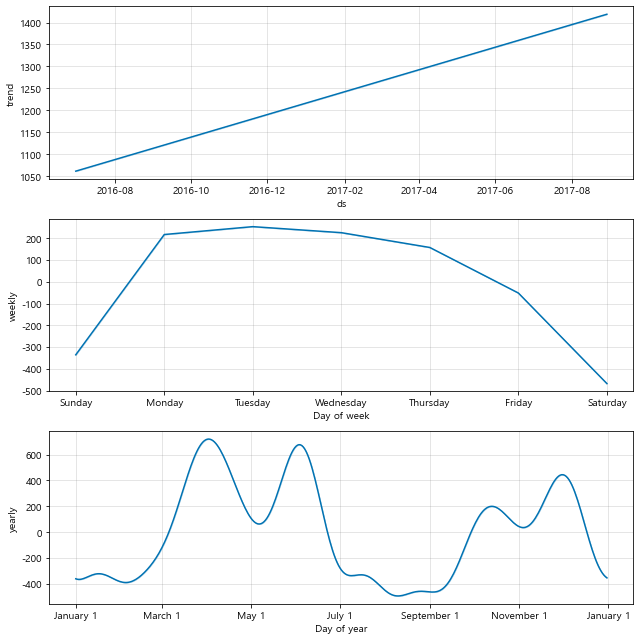

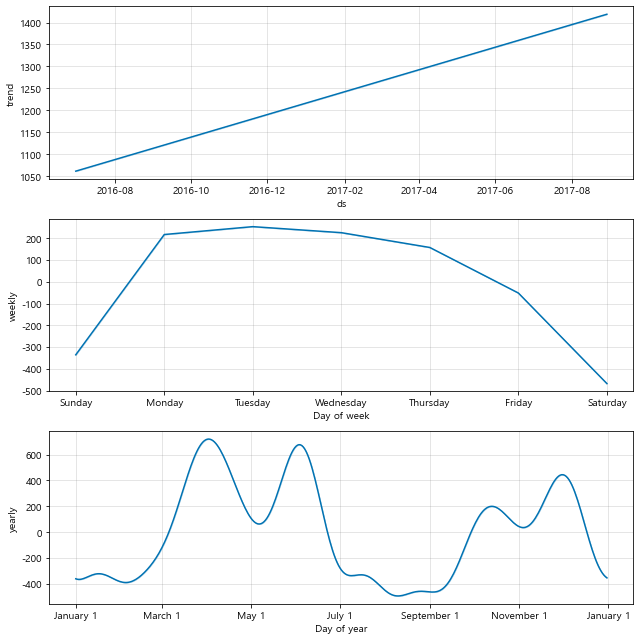

In [12]:
m.plot_components(forecast)

Pandas는 구글이 제공하는 주가 정보를 받아올 수 있는 기능이 있습니다. 바로 DataReader 함수 이니다. 종목 코드를 알면 한국 kospi 주가 저오도 받아올 수 있습니다.

In [13]:
start = datetime(2013, 1, 1)
end = datetime(2017, 6, 30)

KIA = web.DataReader('000270.KS', data_source='yahoo', start=start, end=end)
KIA.head()

High    Low   Open  Close   Volume  Adj Close
Date                                                      
2013-01-02  57400  56000  57000  56300  2145047      56300
2013-01-03  56700  54100  56300  54600  4392999      54600
2013-01-04  54600  52700  54300  53600  3916692      53600
2013-01-07  54500  53600  53800  54000  2061988      54000
2013-01-08  54800  53700  53700  54500  1899832      54500

<AxesSubplot:xlabel='Date'>

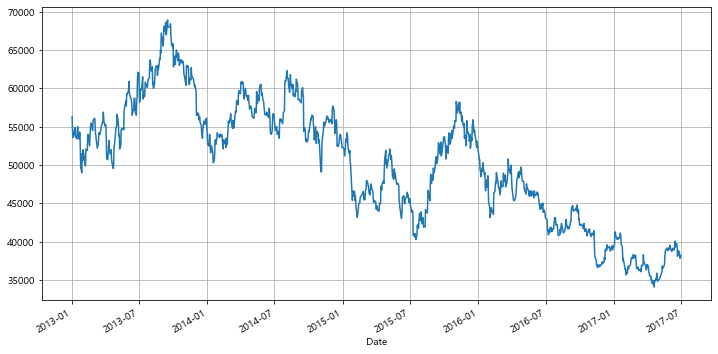

In [14]:
KIA['Close'].plot(figsize=(12, 6), grid=True)

나중에 참 값과의 비교를 위해 일부 데이터를 잘라서 먼저 forest를 수행해 보겠습니다.

In [15]:
KIA_trunc = KIA[:'2016-12-31']
KIA_trunc

High    Low   Open  Close   Volume  Adj Close
Date                                                      
2013-01-02  57400  56000  57000  56300  2145047      56300
2013-01-03  56700  54100  56300  54600  4392999      54600
2013-01-04  54600  52700  54300  53600  3916692      53600
2013-01-07  54500  53600  53800  54000  2061988      54000
2013-01-08  54800  53700  53700  54500  1899832      54500
...           ...    ...    ...    ...      ...        ...
2016-12-23  39350  38650  38700  39100  1070783      39100
2016-12-26  39350  38850  39100  39000   465612      39000
2016-12-27  39700  39050  39050  39500   879686      39500
2016-12-28  39100  38600  38600  38950   662314      38950
2016-12-29  39400  38700  38700  39250   586340      39250

[987 rows x 6 columns]

In [16]:
df = pd.DataFrame({
    'ds': KIA_trunc.index,
    'y': KIA_trunc['Close']
})
df.head()

ds      y
Date                        
2013-01-02 2013-01-02  56300
2013-01-03 2013-01-03  54600
2013-01-04 2013-01-04  53600
2013-01-07 2013-01-07  54000
2013-01-08 2013-01-08  54500

In [17]:
m = Prophet()
m.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [18]:
future = m.make_future_dataframe(periods=365)
future.tail()

ds
1347 2017-12-25
1348 2017-12-26
1349 2017-12-27
1350 2017-12-28
1351 2017-12-29

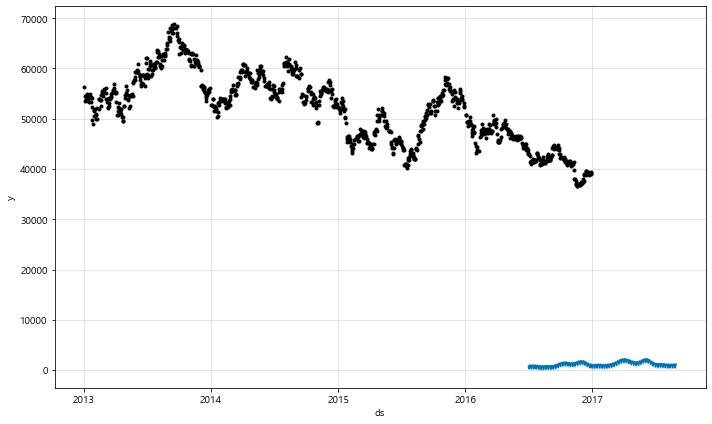

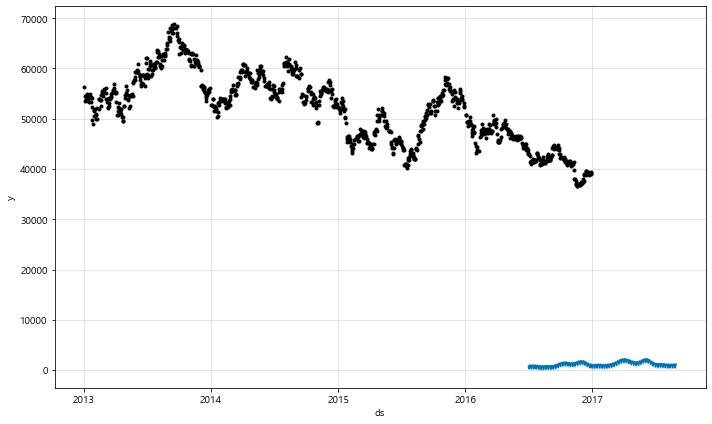

In [19]:
m.plot(forecast)

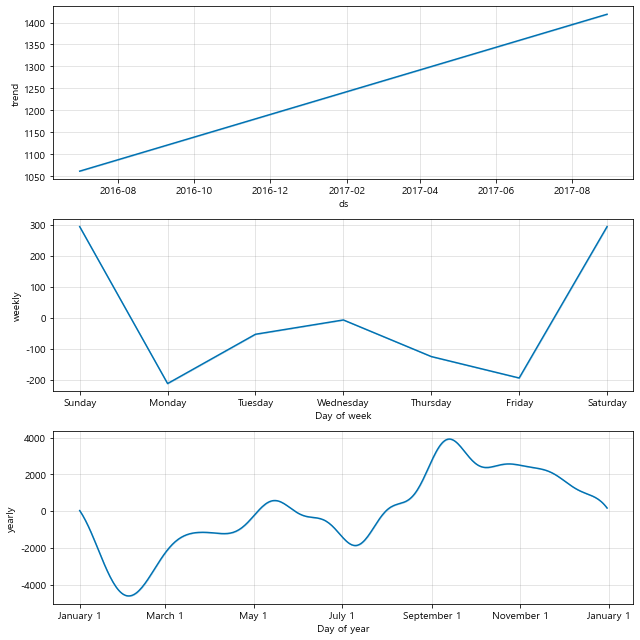

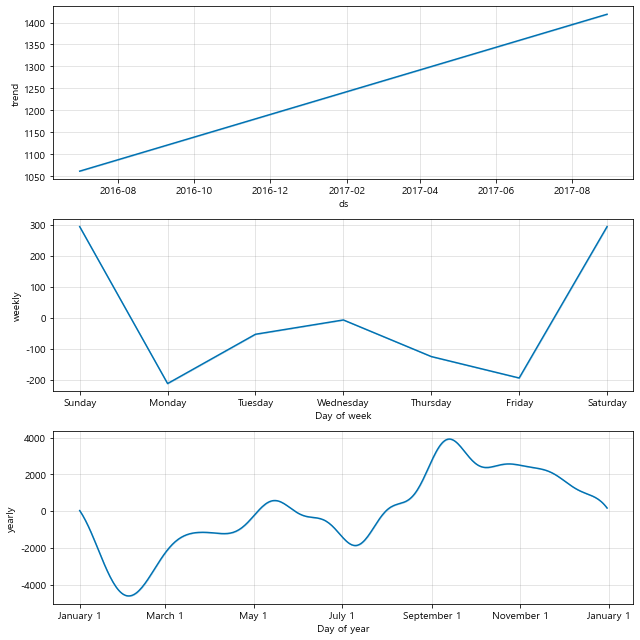

In [20]:
m.plot_components(forecast)

이번에는 주가를 가져오는 날짜를 바꿔서 다시 예측 성능을 확인해보겠습니다.

<AxesSubplot:xlabel='Date'>

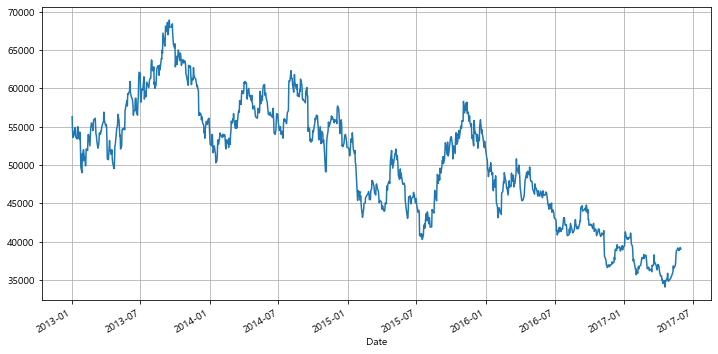

In [21]:
KIA_trunc = KIA[:'2017-05-31']
KIA_trunc['Close'].plot(figsize=(12,6), grid=True)

In [22]:
df = pd.DataFrame({
    'ds': KIA_trunc.index,
    'y': KIA_trunc['Close']
})
df.reset_index(inplace=True)
del df['Date']

In [23]:
m = Prophet()
m.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [27]:
future = m.make_future_dataframe(periods=61)
future.tail()

# del future['Date']

ds
1144 2017-07-27
1145 2017-07-28
1146 2017-07-29
1147 2017-07-30
1148 2017-07-31

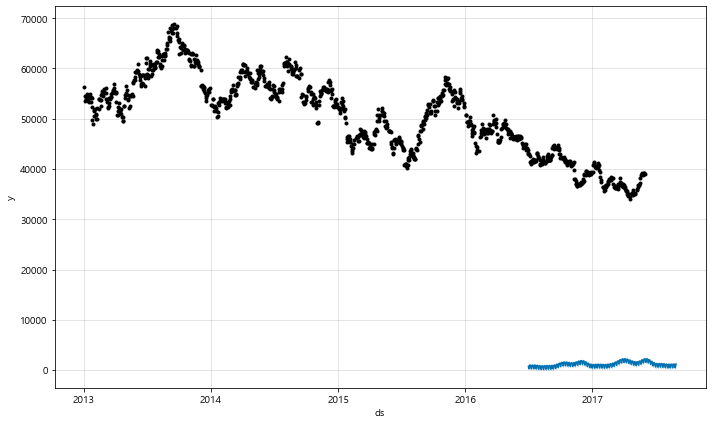

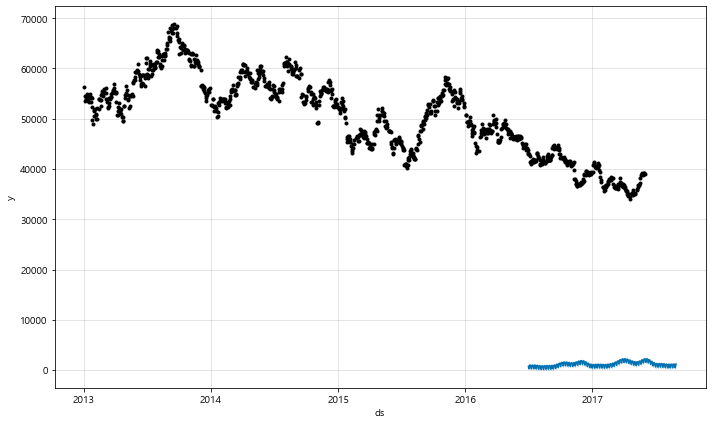

In [28]:
forcast = m.predict(future)
m.plot(forecast)

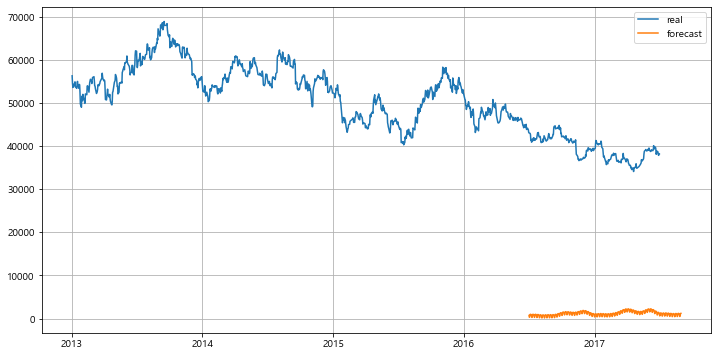

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(KIA.index, KIA.Close, label='real')
plt.plot(forecast.ds, forecast.yhat, label='forecast')
plt.grid()
plt.legend()
plt.show()

## 7-4 Growth Model과 Holiday Forecast

이번 절부터는 prophet의 튜토리얼에 나오는 예제입니다.

In [40]:
df = pd.read_csv('./data/08. example_wp_R.csv')
df['y'] = np.log(df['y'])

In [41]:
df['cap'] = 8.5

In [42]:
m = Prophet(growth='logistic')
m.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


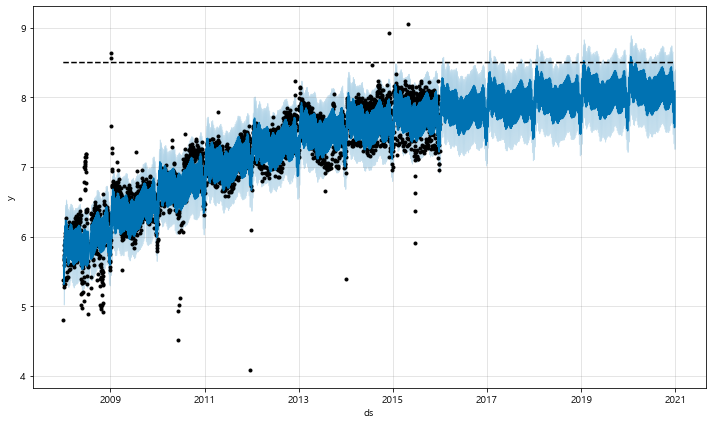

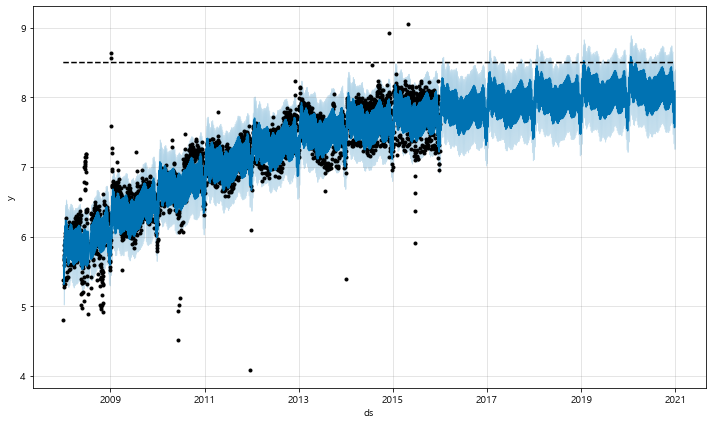

In [43]:
future = m.make_future_dataframe(periods=1826)
future['cap'] = 8.5
fcst = m.predict(future)
m.plot(fcst)

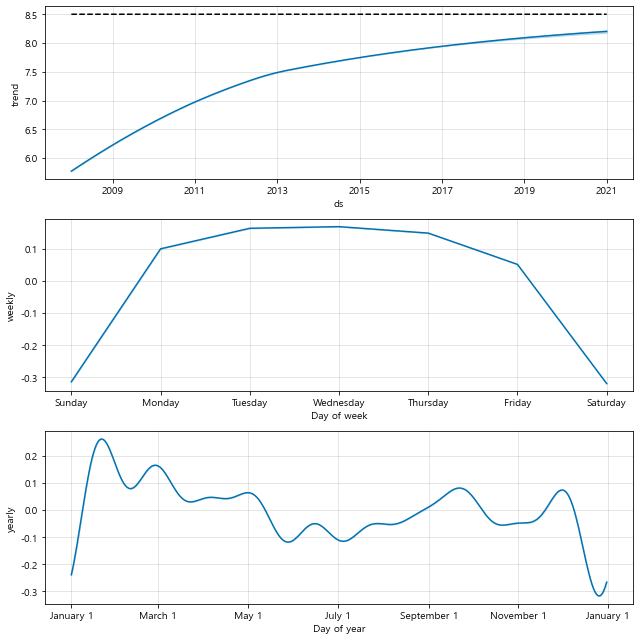

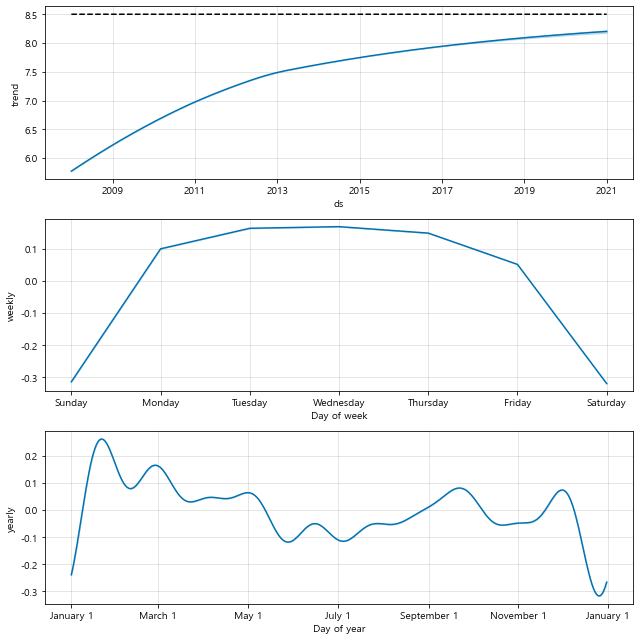

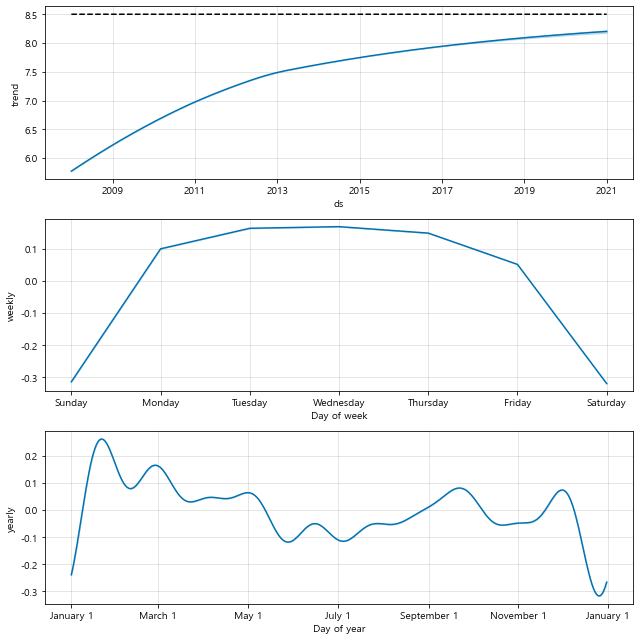

In [44]:
forecast = m.predict(future)
m.plot_components(forecast)